In [1]:
# import requirements
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/sjy/anaconda3/envs/jjs2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:463: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sjy/anaconda3/envs/jjs2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:464: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sjy/anaconda3/envs/jjs2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:465: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sjy/anaconda3/envs/jjs2/lib/p

In [2]:
### main constants

# markers
free_cell_mark = 1.0
visited_cell_mark = 0.8 
agent_cell_mark = 0.5  
obstacle_cell_mark = 0.0
destination_cell_mark = 0.3

# rewards
GOAL = 1.0
REVISIT = -0.25
VALID = -0.04
INVALID = -0.8
# BLOCKED = -0.75


# Actions 
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

ACTION_NUMS = len(actions_dict)

# Exploration factor
epsilon = 0.1

- free cell : 1.0
- visited cell : 0.8
- agent cell : 0.5
- occupied cell : 0.0

In [3]:
fixed_obstacles =  np.array([
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  0.,  0.,  0.,  0.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  0.,  0.,  0.],
    [ 1.,  0.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.]
])

# Grid Environment
class Environment(object):
    def __init__(self, grid_heigth=7, grid_width=7, num_obstacles=7):
        self.height = grid_heigth
        self.width = grid_width
        self.grid = np.ones([self.height, self.width])
        self.free_cells = [(r,c) for r in range(self.grid.shape[0]) for c in range(self.grid.shape[1]) if self.grid[r,c] == 1.0]
        self.obstacle_cells = []
        
        self.reset(num_obstacles)

    def reset(self, num_obstacles=7):
        self.grid = np.ones([self.height, self.width])
        self.free_cells = [(r,c) for r in range(self.grid.shape[0]) for c in range(self.grid.shape[1]) if self.grid[r,c] == 1.0]
        self.obstacle_cells = []
        self.start = (np.random.randint(self.grid.shape[0]), np.random.randint(self.grid.shape[1]))
        self.start = (0,0) # TODO: to be removed - it's for fixed start location, not randomly generated
        self.agent = np.array(self.start)
        if self.start in self.free_cells:
            self.free_cells.remove(self.start)
        self.grid[self.agent[0], self.agent[1]] = agent_cell_mark
        self.destination = (np.random.randint(self.grid.shape[0]), np.random.randint(self.grid.shape[1]))
        self.destination = (self.grid.shape[0]-1,self.grid.shape[1]-1) # TODO: to be removed - it's for fixed start location, not randomly generated
        while np.array_equal(self.start, self.destination):
            self.destination = (np.random.randint(self.grid.shape[0]), np.random.randint(self.grid.shape[1]))
        self.grid[self.destination[0], self.destination[1]] = destination_cell_mark
        
        # TODO: to be uncommented - randomly genererate the obstacles
#         for _ in range(num_obstacles):
#             x, y = np.random.randint(self.grid.shape[0]), np.random.randint(self.grid.shape[1])
#             if (x == self.start[0] and y == self.start[1]) or (x == self.destination[0] and y == self.destination[1]):
#                 continue
#             self.grid[x, y] = obstacle_cell_mark
#             if (x,y) in self.free_cells:
#                 self.free_cells.remove((x,y))
#             self.obstacle_cells.append((x,y))
        
        # TODO: to be removed - it's for fixed start location, not randomly generated
        for x in range(fixed_obstacles.shape[0]):
            for y in range(fixed_obstacles.shape[1]):
                if fixed_obstacles[x, y] == obstacle_cell_mark:
                    self.grid[x, y] = obstacle_cell_mark
                    if (x,y) in self.free_cells:
                        self.free_cells.remove((x,y))
                    self.obstacle_cells.append((x,y))
        
        self.min_reward = -0.5 * self.grid.size
        self.agent_state = (self.agent[0], self.agent[1], 'start')
        
        self.total_reward = 0.0
        
        self.visited = set()
        

    def update_state(self, action):
        nrows, ncols = self.grid.shape
        nrow, ncol, nmode = agent_row, agent_col, mode = self.agent_state

        if self.grid[agent_row, agent_col] > 0.0:
            self.visited.add((agent_row, agent_col))  # mark visited cell

        valid_actions = self.get_valid_actions()
                
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in agent position
            mode = 'invalid'

        # new state
        self.agent_state = (nrow, ncol, nmode)
        self.grid[self.agent[0], self.agent[1]] = visited_cell_mark
        self.agent = (nrow, ncol)
        self.grid[self.agent[0], self.agent[1]] = agent_cell_mark

    def get_reward(self):
        agent_row, agent_col, mode = self.agent_state
        nrows, ncols = self.grid.shape
        if agent_row == self.destination[0] and agent_col == self.destination[1]:
            return GOAL
        if mode == 'blocked':
            return self.min_reward - 1 ###################????
        if (agent_row, agent_col) in self.visited:
            return REVISIT
        if mode == 'invalid':
            return INVALID
        if mode == 'valid':
            return VALID

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.grid)
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        agent_row, agent_col, mode = self.agent_state
        nrows, ncols = self.grid.shape
        if agent_row == self.destination[0] and agent_col == self.destination[1]:
            return 'win'

        return 'not_over'

    def get_valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.agent_state
        else:
            row, col = cell
        actions = [LEFT, UP, RIGHT, DOWN]
        nrows, ncols = self.grid.shape
        if row == 0:
            actions.remove(UP)
        elif row == nrows-1:
            actions.remove(DOWN)

        if col == 0:
            actions.remove(LEFT)
        elif col == ncols-1:
            actions.remove(RIGHT)

        if row>0 and self.grid[row-1,col] == obstacle_cell_mark:
            actions.remove(UP)
        if row<nrows-1 and self.grid[row+1,col] == obstacle_cell_mark:
            actions.remove(DOWN)

        if col>0 and self.grid[row,col-1] == obstacle_cell_mark:
            actions.remove(LEFT)
        if col<ncols-1 and self.grid[row,col+1] == obstacle_cell_mark:
            actions.remove(RIGHT)

        return actions

In [4]:
def render(env):
    plt.grid('on')
    nrows, ncols = env.grid.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    canvas = np.copy(env.grid)
    
    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'blue', 'skyblue', 'gray'])
    bounds = [0.0, 0.299, 0.5, 0.799, 0.801, 1.0]
    #bounds=[0.0, 0.3, 0.5, 0.8, 1.0]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    img = plt.imshow(canvas, cmap=cmap, norm=norm, interpolation='none')
    return img

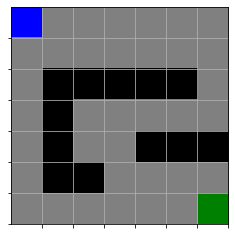

In [5]:
grid_world = Environment()
render(grid_world)

[[0.5 1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.  0.  0.  0.  0.  1. ]
 [1.  0.  1.  1.  1.  1.  1. ]
 [1.  0.  1.  1.  0.  0.  0. ]
 [1.  0.  0.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  0.3]]
(1, 49)


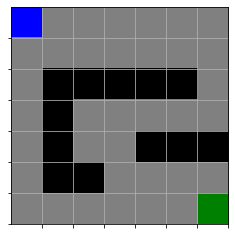

In [6]:
# canvas, reward, game_over = grid_world.act(UP)
render(grid_world)
print(grid_world.grid)
print(grid_world.observe().shape)

In [7]:
def play_game(model, env):
    env.reset()
    envstate = env.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = env.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

def completion_check(env):
    if not env.get_valid_actions(env.start):
        return False
    if not env.get_valid_actions(env.destination):
        return False
    return True



In [8]:
completion_check(grid_world)

True

episode = [envstate, action, reward, envstate_next, game_over]

    - envstate : environment state 임. 모든 cell 의 상태를 의미. neural network 를 더 쉽게 하기 위해서, grid 를 1차원 vector 로 넣을 거임
    - action : 4개의 action 중 하나 (0,1,2,3)
    - reward : action 에서 얻은 reward
    - envstate_next : last action 에 의해 transition 된 grid environment
    - game_over : True 또는 False. game 이 끝났는지를 가리킴. Agent 가 destination cell 에 도달하거나, negative reward limit 에 도달하면 끝남. 각각 win 과 lose

In [9]:
# Memory for Episodes
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [envstate, action, reward, envstate_next, game_over]
        # memory[i] = episode
        # envstate == flattened 1d grid cells info, including rat cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode), 첫번째 episode 의 첫번째 element(envstate[1,64])
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

In [10]:
def build_model(env, lr=0.001):
    model = Sequential()
    model.add(Dense(env.grid.size, input_shape=(env.grid.size,)))
    model.add(PReLU())
    model.add(Dense(env.grid.size))
    model.add(PReLU())
    model.add(Dense(ACTION_NUMS))
    model.compile(optimizer='adam', loss='mse')
    return model

In [11]:
def qtrain(model, epochs, max_memory, data_size, weights_file = "", name = ""):
    global epsilon
#     n_epoch = opt.get('epochs', 15000)
#     max_memory = opt.get('max_memory', 1000)
#     data_size = opt.get('data_size', 50)
#     weights_file = opt.get('weights_file', "")
#     name = opt.get('name', 'model')
    
    n_epoch = epochs
    max_memory = max_memory
    data_size = data_size
    weights_file = weights_file
    name = name
    start_time = datetime.datetime.now()

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_weights(weights_file)

    # Construct environment
    env = Environment()
    while not completion_check(env):
        env = Environment()

    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)

    win_history = []   # history of win/lose game
    hsize = env.grid.size//2   # history window size
    win_rate = 0.0

    for epoch in range(n_epoch):
        loss = 0.0
        env.reset()
        while not completion_check(env):
            env.reset()
        
        game_over = False

        # get initial envstate (1d flattened canvas)
        envstate = env.observe()

        n_episodes = 0
        while not game_over:
            valid_actions = env.get_valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))

            # Apply action, get reward and new envstate
            envstate, reward, game_status = env.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1

            # Train neural network model
            inputs, targets = experience.get_data(data_size=data_size)
            h = model.fit(
                inputs,
                targets,
                nb_epoch=8,
                batch_size=16,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=0)

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
    
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # we simply check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(env):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    # Save trained model weights and architecture, this will be used by the visualization code
    h5file = name + ".h5"
    json_file = name + ".json"
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return 

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [12]:
temp_env = Environment()
model = build_model(temp_env)
qtrain(model, epochs=1000, max_memory=8*temp_env.grid.size, data_size=32, name="result_weight")

Epoch: 000/999 | Loss: 0.0373 | Episodes: 71 | Win count: 1 | Win rate: 0.000 | time: 3.3 seconds
Epoch: 001/999 | Loss: 0.0273 | Episodes: 109 | Win count: 1 | Win rate: 0.000 | time: 9.3 seconds
Epoch: 002/999 | Loss: 0.0049 | Episodes: 90 | Win count: 2 | Win rate: 0.000 | time: 14.5 seconds
Epoch: 003/999 | Loss: 0.0063 | Episodes: 109 | Win count: 2 | Win rate: 0.000 | time: 21.0 seconds
Epoch: 004/999 | Loss: 0.0180 | Episodes: 22 | Win count: 3 | Win rate: 0.000 | time: 22.3 seconds
Epoch: 005/999 | Loss: 0.0039 | Episodes: 22 | Win count: 4 | Win rate: 0.000 | time: 23.6 seconds
Epoch: 006/999 | Loss: 0.0153 | Episodes: 116 | Win count: 4 | Win rate: 0.000 | time: 30.6 seconds
Epoch: 007/999 | Loss: 0.0045 | Episodes: 34 | Win count: 5 | Win rate: 0.000 | time: 32.6 seconds
Epoch: 008/999 | Loss: 0.0092 | Episodes: 18 | Win count: 6 | Win rate: 0.000 | time: 33.7 seconds
Epoch: 009/999 | Loss: 0.0149 | Episodes: 18 | Win count: 7 | Win rate: 0.000 | time: 34.8 seconds
Epoch: 01

In [13]:
from IPython.display import HTML
from IPython.display import display

In [14]:
import copy

def demonstrate(model, epoch = 2):
    for i in range(epoch):
        rendered_imgs = []
        count = 0
        
        env = Environment()
        while not completion_check(env):
            env = Environment()
        envstate = env.observe()
        rendered_imgs.append(render(env))
        plt.savefig("demo/"+str(i)+"-"+str(count)+".png")
        count += 1
        while True:
            prev_envstate = envstate
            q = model.predict(prev_envstate)
            action = np.argmax(q[0])
            envstate, reward, game_status = env.act(action)
            print(count, action)
            rendered_imgs.append(render(env))
            plt.savefig("demo/"+str(i)+"-"+str(count)+".png")
            count += 1
            if game_status == 'win':
                print("win")
                break
            elif game_status == 'lose':
                print("lose")
                break
#         while True:
#             prev_envstate = envstate
#             # get next action
#             q = model.predict(prev_envstate)
#             action = np.argmax(q[0])

#             # apply action, get rewards and new state
#             envstate, reward, game_status = env.act(action)
#             rendered_imgs.append(render(env))
#             if game_status == 'win':
#                 break
#             elif game_status == 'lose':
#                 break
        print(len(rendered_imgs))
#         count = 0
#         for img in rendered_imgs:
#             plt.savefig(img, "demo/"+str(i)+"-"+str(count)+".png")
#             count += 1

1 2
2 3
3 2
4 2
5 2
6 2
7 2
8 3
9 3
10 0
11 0
12 0
13 3
14 3
15 2
16 3
17 2
18 2
win
19


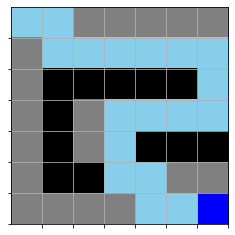

In [15]:
demonstrate(model, 1)